In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [2]:
# Get training property info

filename = 'Data/train_2016.csv'
trainid_df = pd.read_csv(filename)

# Get property info

filename = 'Data/properties_2016.csv'
properties_df = pd.read_csv(filename)

C:\Users\Matthew\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Put respective properties_df info into train_df.

properties_df.set_index('parcelid', inplace = True)
trainid_df.set_index('parcelid', inplace = True)

all_df = trainid_df.join(properties_df)

In [4]:
# Only use the necessary data.

all_df = all_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
all_df = all_df.dropna()

npoints = len(all_df.logerror.values)
origerror = np.mean(np.abs(all_df.logerror.values))

In [5]:
# Make function for binning values in an array

def makebins(X, nbins = 50):
    X2 = X.copy()
    maxval = np.amax(X2)
    minval = np.amin(X2)
    X2 = (X2 - minval) / (maxval - minval) * nbins
    X2 = X2.astype(int)
    X2 = minval + X2 * (maxval - minval) / nbins
    return X2

# Make function for bin fit. Assume data in X is already in bins ( so we don't bin year built in the same way).

def binfit(X, y, nbins = 10):
    nrows, nXcols = X.shape
    alldata = np.hstack((X, y))
    Xnames = ['X' + str(i) for i in range(nXcols)]
    colnames = Xnames + ['y']
    new_df = pd.DataFrame(alldata, columns = colnames)
    grouped_df = new_df.groupby(Xnames).median()
    predictdict = {t : py for t, py in zip(grouped_df.index.values, grouped_df.y.values)}
    return predictdict

def bintransform(X, y, valdict):
    nrows, nXcols = X.shape
    ypredict = []
    for row in X:
        
        key = tuple(row)
        
        # If key isn't present for some reason, then just assume
        # the zillow model is correct.
        
        if key in valdict:
            ypredict.append(valdict[key])
        else:
            ypredict.append(0.0)
    
    return np.array(ypredict).reshape(-1,1)

In [6]:
# Let's get a benchmark for how well a simple piecewise constant function will perform.

tobin = ['latitude', 'longitude']
bins = np.zeros((npoints, len(tobin)))

for i in range(len(tobin)):
    bins[:, i] = makebins(all_df[tobin[i]].values, nbins = 6)
    all_df['bin' + str(i)] = bins[:, i]
    
X = np.hstack((bins, all_df.yearbuilt.values.reshape(-1,1)))
    
y = all_df.logerror.values.reshape(-1,1)

predictdict = binfit(X, y)
ypredict = bintransform(X, y, predictdict)

yerror = np.abs(ypredict - y)
yerror = np.mean(yerror)
print(yerror)

relerror = (yerror - origerror) / origerror
print(relerror)

0.0661815424658
-0.0252870847278


In [7]:
# Now let's check with validation.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.1, random_state = 50)

predictdict = binfit(X_train, y_train)

# First check results on training data
print('For training data')

ypredict = bintransform(X_train, y_train, predictdict)
yerror = np.abs(ypredict - y_train)
yerror = np.mean(yerror)
print(yerror)

relerror = (yerror - origerror) / origerror
print(relerror)

# Now validate on testing data.

print('For test data')
ypredict = bintransform(X_test, y_test, predictdict)

yerror = np.abs(ypredict - y_test)
yerror = np.mean(yerror)
print(yerror)

relerror = (yerror - origerror) / origerror
print(relerror)

For training data
0.0662064232254
-0.0249206442254
For test data
0.0674688896336
-0.00632720763668


In [8]:
# Let's see how training error and testing error depends on the number of bins.

tobin = ['latitude', 'longitude']
bins = np.zeros((npoints, len(tobin)))
setofnbins = range(1,100, 5)

errors = {'train' : [], 'test' : []}

for nbins in setofnbins:
    
    for i in range(len(tobin)):
        bins[:, i] = makebins(all_df[tobin[i]].values, nbins = nbins)
    
    X = np.hstack((bins, all_df.yearbuilt.values.reshape(-1,1)))
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 50)

    predictdict = binfit(X_train, y_train)
    
    # Get training error.
    
    ypredict = bintransform(X_train, y_train, predictdict)
    yerror = np.abs(ypredict - y_train)
    yerror = np.mean(yerror)
    errors['train'].append(yerror)
    
    # Get test error.
    
    ypredict = bintransform(X_test, y_test, predictdict)
    yerror = np.abs(ypredict - y_test)
    yerror = np.mean(yerror)
    errors['test'].append(yerror)
        
errors = {key : np.array(errors[key]) for key in errors}
relerrors = {key : (errors[key] - origerror) /  origerror for key in errors}

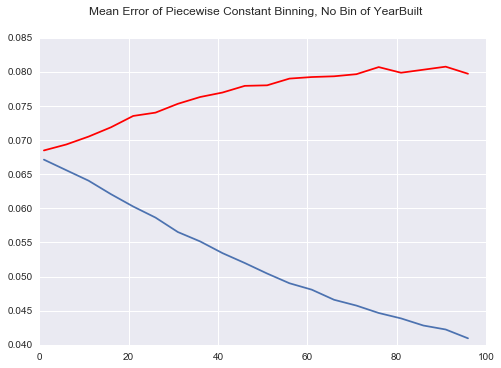

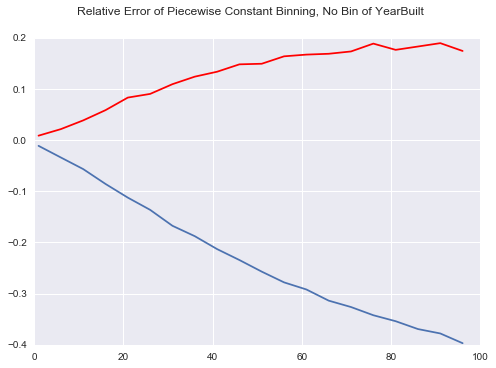

In [9]:
# Plot results of training and test error depending on the number of bins.

plt.plot(setofnbins, errors['test'], color = 'red')
plt.plot(setofnbins, errors['train'])
plt.suptitle('Mean Error of Piecewise Constant Binning, No Bin of YearBuilt')
plt.show()

plt.plot(setofnbins, relerrors['test'], color = 'red')
plt.plot(setofnbins, relerrors['train'])
plt.suptitle('Relative Error of Piecewise Constant Binning, No Bin of YearBuilt')
plt.show()

In [10]:
# Now let's see how training error and testing error depends on the number of bins when we also bin the yearbuilt
# values.

tobin = ['latitude', 'longitude', 'yearbuilt']
bins = np.zeros((npoints, len(tobin)))
setofnbins = range(1,100, 5)

errors = {'train' : [], 'test' : []}

for nbins in setofnbins:
    
    for i in range(len(tobin)):
        bins[:, i] = makebins(all_df[tobin[i]].values, nbins = nbins)
    
    X = bins
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 50)

    predictdict = binfit(X_train, y_train)
    
    # Get training error.
    
    ypredict = bintransform(X_train, y_train, predictdict)
    yerror = np.abs(ypredict - y_train)
    yerror = np.mean(yerror)
    errors['train'].append(yerror)
    
    # Get test error.
    
    ypredict = bintransform(X_test, y_test, predictdict)
    yerror = np.abs(ypredict - y_test)
    yerror = np.mean(yerror)
    errors['test'].append(yerror)
        
errors = {key : np.array(errors[key]) for key in errors}
relerrors = {key : (errors[key] - origerror) /  origerror for key in errors}

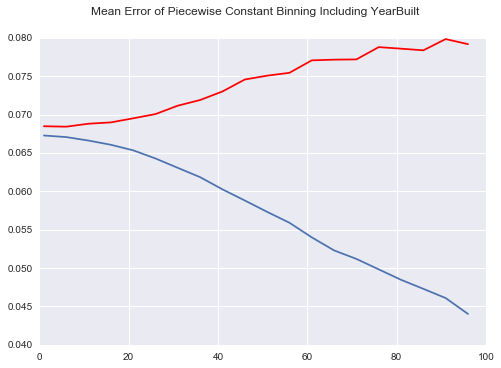

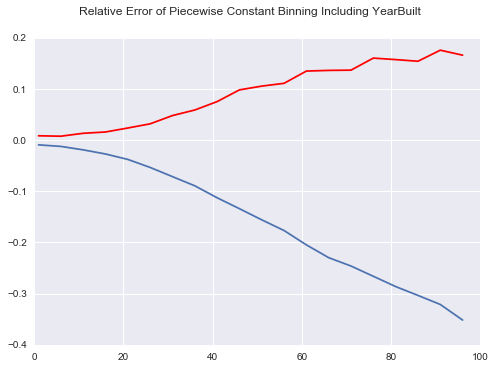

In [11]:
# Plot results of training and test error depending on the number of bins.

plt.plot(setofnbins, errors['test'], color = 'red')
plt.plot(setofnbins, errors['train'])
plt.suptitle('Mean Error of Piecewise Constant Binning Including YearBuilt')
plt.show()

plt.plot(setofnbins, relerrors['test'], color = 'red')
plt.plot(setofnbins, relerrors['train'])
plt.suptitle('Relative Error of Piecewise Constant Binning Including YearBuilt')
plt.show()

In [115]:
# Define simple gradient descent for linear fit.

def l1linearfit(X, y, niterations, rate):
    npoints, nvars = X.shape
    coefficients = np.zeros(nvars)
    errors = []
    for i in range(niterations):
        grad = np.zeros(X.shape)
        ypredict = np.dot(X, coefficients.T)
        error = ypredict - y
        
        # Get grad update matrix
        # First the positive ones
        grad[error >= 0] = X[error >= 0]
        grad[error < 0] = -1 * X[error < 0]
        
        grad = np.sum(grad, axis = 0)
        coefficients -= grad * rate
        
        error = np.abs(error)
        error = np.mean(error)
        errors.append(error)
        
    return coefficients, errors

def l1linearfit2(X, y, initial, niterations, rate):
    npoints, nvars = X.shape
    coefficients = initial.copy()
    errors = []
    for i in range(niterations):
        grad = np.zeros(X.shape)
        ypredict = np.dot(X, coefficients.T)
        error = ypredict - y
        
        # Get grad update matrix
        # First the positive ones
        grad[error >= 0] = X[error >= 0]
        grad[error < 0] = -1 * X[error < 0]
        
        grad = np.sum(grad, axis = 0)
        coefficients -= grad * rate
        
        error = np.abs(error)
        error = np.mean(error)
        errors.append(error)
        
    return coefficients, errors

(89519,)


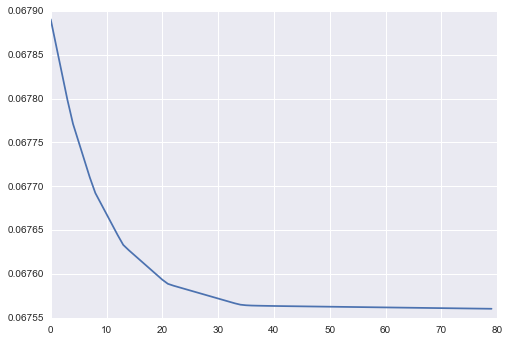

In [26]:
# Now let's just try a linear function of yearbuilt, but with validation.

X = all_df.yearbuilt.values.reshape(-1,1)
nrows, ncols = X.shape
constcol = np.full((nrows, 1), 1.0)
X = np.hstack((X,constcol))

y = all_df.logerror.values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 2)

print(y.shape)
coeffs, errors = l1linearfit(X_train, y_train, niterations = 80, rate = 10**-14)

plt.plot(errors)
plt.show()

In [27]:
# Get errors of linear fit for training and test.

print('For training')
ypredict = np.dot(X_train, coeffs.T)
error = np.abs(ypredict - y_train)
error = np.mean(error)
print(error)

relerror = (error - origerror) / origerror
print(relerror)

# Now do test data
print('For test data')
ypredict = np.dot(X_test, coeffs.T)
error = np.abs(ypredict - y_test)
error = np.mean(error)
print(error)
relerror = (error - origerror) / origerror
print(relerror)

For training
0.0675602198012
-0.00498210913042
For test data
0.0676515280524
-0.0036373334058


In [65]:
# Set up diffusions for specific choice of neighbors and epsilon.

k = 30
epsilon = 10**4

coords = all_df[['latitude', 'longitude']].values
diffinit = all_df['yearbuilt'].values
nbrs = NearestNeighbors()
nbrs.fit(coords)

nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)
nbrdiffusions = diffinit[nbrindex]
                         
weights = nbrdistance + epsilon
weights = 1.0 / weights
meandiffusions = weights * nbrdiffusions
meandiffusions = np.sum(meandiffusions, axis = 1)
meandiffusions /= np.sum(weights, axis = 1)
diffusions = meandiffusions

print(diffusions.shape)
all_df['diffusions'] = diffusions

(89519,)


(89519,)


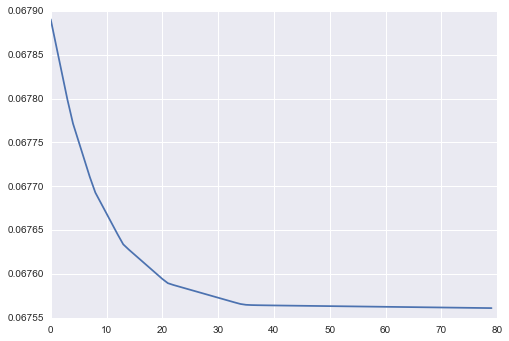

In [66]:
# Now let's just try a linear function of diffusions, but with validation.

X = all_df.diffusions.values.reshape(-1,1)
nrows, ncols = X.shape
constcol = np.full((nrows, 1), 1.0)
X = np.hstack((X,constcol))

y = all_df.logerror.values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 2)

print(y.shape)
coeffs, errors = l1linearfit(X_train, y_train, niterations = 80, rate = 10**-14)

plt.plot(errors)
plt.show()

In [67]:
# Get errors of linear fit for training and test.

print('For training')
ypredict = np.dot(X_train, coeffs.T)
error = np.abs(ypredict - y_train)
error = np.mean(error)
print(error)

relerror = (error - origerror) / origerror
print(relerror)

# Now do test data
print('For test data')
ypredict = np.dot(X_test, coeffs.T)
error = np.abs(ypredict - y_test)
error = np.mean(error)
print(error)
relerror = (error - origerror) / origerror
print(relerror)

For training
0.0675609881657
-0.0049707927614
For test data
0.067652149988
-0.00362817362144


(89519,)


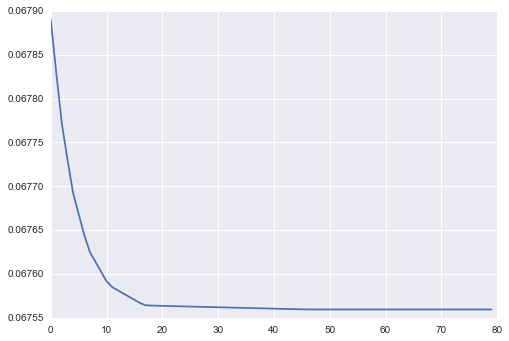

In [68]:
# Now let's do a linear fit on diffusions and yearbuilt.

X = all_df[['yearbuilt', 'diffusions']].values
nrows, ncols = X.shape
constcol = np.full((nrows, 1), 1.0)
X = np.hstack((X,constcol))

y = all_df.logerror.values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 2)

print(y.shape)
coeffs, errors = l1linearfit(X_train, y_train, niterations = 80, rate = 10**-14)

plt.plot(errors)
plt.show()

In [69]:
# Get errors of linear fit for training and test.

print('For training')
ypredict = np.dot(X_train, coeffs.T)
error = np.abs(ypredict - y_train)
error = np.mean(error)
print(error)

relerror = (error - origerror) / origerror
print(relerror)

# Now do test data
print('For test data')
ypredict = np.dot(X_test, coeffs.T)
error = np.abs(ypredict - y_test)
error = np.mean(error)
print(error)
relerror = (error - origerror) / origerror
print(relerror)

For training
0.0675595278143
-0.00499230062041
For test data
0.0676533673602
-0.0036102443257


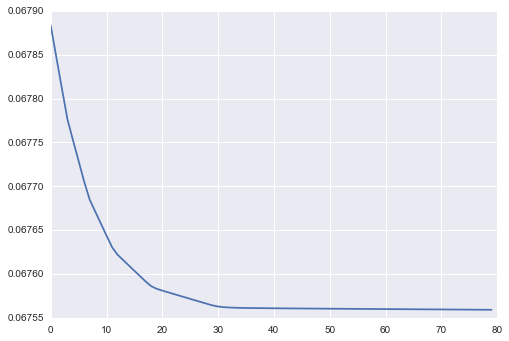

array([  1.21436000e-16,   2.43907902e-13,   2.42597575e-13,
         4.89796242e-10,   4.87108746e-10,   4.84543954e-10])

In [70]:
# Now let's try linear fits using polynomial elements.

quadfeatures = PolynomialFeatures(2)
X = all_df[['yearbuilt', 'diffusions']].values
X = quadfeatures.fit_transform(X)

y = all_df.logerror.values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 0)

coeffs, errors = l1linearfit(X_train, y_train, 80, 10**-21)

plt.plot(errors)
plt.show()

coeffs

In [71]:
# Get errors of linear fit for training and test.

print('For training')
ypredict = np.dot(X_train, coeffs.T)
error = np.abs(ypredict - y_train)
error = np.mean(error)
print(error)

relerror = (error - origerror) / origerror
print(relerror)

# Now do test data
print('For test data')
ypredict = np.dot(X_test, coeffs.T)
error = np.abs(ypredict - y_test)
error = np.mean(error)
print(error)
relerror = (error - origerror) / origerror
print(relerror)

For training
0.0675591017205
-0.00499857607394
For test data
0.0676488788126
-0.00367635105648


In [116]:
# For kicks, let's do poly fit using built in linear regressor.

quadfeatures = PolynomialFeatures(2)
X = all_df[['yearbuilt', 'diffusions']].values
X = quadfeatures.fit_transform(X)

y = all_df.logerror.values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 0)

linear = linear_model.LinearRegression()
linear.fit(X_train, y_train)
linear.coef_

array([  0.00000000e+00,   1.44447014e-03,   1.59061757e-02,
         4.25091104e-06,  -9.18508157e-06,   5.64131927e-07])

In [117]:
# Get errors of linear fit for training and test.

print('For training')
ypredict = linear.predict(X_train)
error = np.abs(ypredict - y_train)
error = np.mean(error)
print(error)

relerror = (error - origerror) / origerror
print(relerror)

# Now do test data
print('For test data')
ypredict = linear.predict(X_test)
error = np.abs(ypredict - y_test)
error = np.mean(error)
print(error)
relerror = (error - origerror) / origerror
print(relerror)

For training
0.0678682935981
-0.000444839409149
For test data
0.0680415137093
0.0021063232449


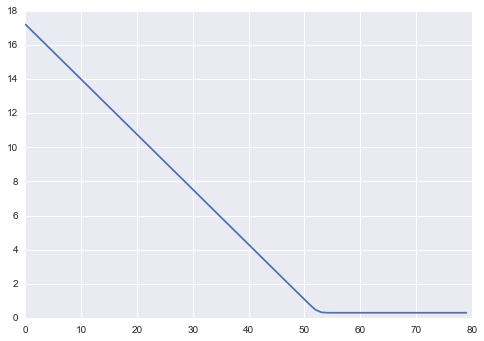

array([ -3.84393000e-13,   1.44446938e-03,   1.59061750e-02,
         2.77499231e-06,  -1.06630949e-05,  -9.16061343e-07])

In [124]:
# Now let's try running L1 gradient descent starting from coefficients of built in regressor.

quadfeatures = PolynomialFeatures(2)
X = all_df[['yearbuilt', 'diffusions']].values
X = quadfeatures.fit_transform(X)
initial = linear.coef_

y = all_df.logerror.values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 0)

coeffs, errors = l1linearfit2(X_train, y_train, initial, 80, 10**-19)

plt.plot(errors)
plt.show()

coeffs

In [125]:
# Get errors of linear fit for training and test.

print('For training')
ypredict = np.dot(X_train, coeffs.T)
error = np.abs(ypredict - y_train)
error = np.mean(error)
print(error)

relerror = (error - origerror) / origerror
print(relerror)

# Now do test data
print('For test data')
ypredict = np.dot(X_test, coeffs.T)
error = np.abs(ypredict - y_test)
error = np.mean(error)
print(error)
relerror = (error - origerror) / origerror
print(relerror)

For training
0.295633495051
3.35405061709
For test data
0.294953578827
3.34403690179


In [93]:
# Let's try nearest neighbors.

X = all_df[['latitude', 'longitude', 'yearbuilt', 'diffusions']].values
y = all_df.logerror.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 1)

nbrs = KNeighborsRegressor(n_neighbors = 50)
nbrs.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=50, p=2,
          weights='uniform')

In [94]:
# Get errors of linear fit for training and test.

print('For training')
ypredict = nbrs.predict(X_train)
error = np.abs(ypredict - y_train)
error = np.mean(error)
print(error)

relerror = (error - origerror) / origerror
print(relerror)

# Now do test data
print('For test data')
ypredict = nbrs.predict(X_test)
error = np.abs(ypredict - y_test)
error = np.mean(error)
print(error)
relerror = (error - origerror) / origerror
print(relerror)

For training
0.0701173522586
0.0326789960573
For test data
0.0705436053396
0.0389567944847


In [89]:
# Let's try nearest neighbors without diffusions.

X = all_df[['latitude', 'longitude', 'yearbuilt']].values
y = all_df.logerror.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = 0)

nbrs = KNeighborsRegressor(n_neighbors = 50)
nbrs.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=50, p=2,
          weights='uniform')

In [90]:
# Get errors of linear fit for training and test.

print('For training')
ypredict = nbrs.predict(X_train)
error = np.abs(ypredict - y_train)
error = np.mean(error)
print(error)

relerror = (error - origerror) / origerror
print(relerror)

# Now do test data
print('For test data')
ypredict = nbrs.predict(X_test)
error = np.abs(ypredict - y_test)
error = np.mean(error)
print(error)
relerror = (error - origerror) / origerror
print(relerror)

For training
0.0699559590589
0.0303020185743
For test data
0.071168338807
0.0481577855249
